In [ ]:
import torch_sparse
from torch_geometric.loader import NeighborLoader
print("torch-sparse version:", torch_sparse.__version__)

In [4]:
from torch_geometric.datasets import Planetoid
 
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]
 
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
 
# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [6]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
 
# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)
 
# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[419, 500], edge_index=[2, 464], y=[419], train_mask=[419], val_mask=[419], test_mask=[419], n_id=[419], e_id=[464], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[268, 500], edge_index=[2, 311], y=[268], train_mask=[268], val_mask=[268], test_mask=[268], n_id=[268], e_id=[311], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[289, 500], edge_index=[2, 324], y=[289], train_mask=[289], val_mask=[289], test_mask=[289], n_id=[289], e_id=[324], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[189, 500], edge_index=[2, 225], y=[189], train_mask=[189], val_mask=[189], test_mask=[189], n_id=[189], e_id=[225], input_id=[12], batch_size=12)


/home/ubuntu/anaconda3/envs/grp/lib/python3.9/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [7]:
import numpy as np
print(np.__version__)

1.26.2


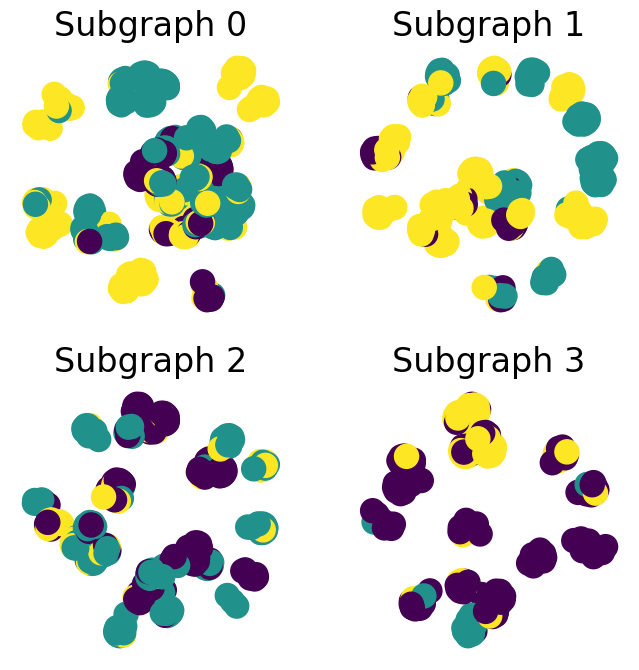

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Plot each subgraph
fig = plt.figure(figsize=(8,8))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [9]:
def accuracy(pred_y, y):
    """정확도 계산"""
    return ((pred_y == y).sum() / len(y)).item()
    
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
 
class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h) # default = mean aggregator
        self.sage2 = SAGEConv(dim_h, dim_out)
 
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)
 
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
 
        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0
 
            # Train on batches
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()
 
                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
 
            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')
 
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [10]:
# GraphSAGE 생성
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)
 
# Train
graphsage.fit(data, 200)
 
# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.314 | Train Acc:  28.77% | Val Loss: 1.12 | Val Acc: 24.94%
Epoch  20 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 66.43%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 84.72%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 75.13%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.45 | Val Acc: 83.33%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.47 | Val Acc: 83.02%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.50 | Val Acc: 80.35%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.44 | Val Acc: 77.43%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 78.22%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.33 | Val Acc: 84.15%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00